# Clustering

#### Import the libraries

In [1847]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go


# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))
from configs.path_config import EXTRACTED_DATA_DIR, OUTPUT_DIR

#### Load the data

In [1848]:
def load_data(path):
    """
    Description: Load data from a csv file containing strain distributions.

    Args:
        path (path object): The path to the csv file.

    Returns:
        df (pd DataFrame): The data loaded from the csv file.
    """
    df = pd.read_csv(path)
    df.isna().sum().sum()

    return df

path = EXTRACTED_DATA_DIR / 'strain_distributions' / 'alvbrodel_04' / 'S-B_Close_Comp_20091129120000_20210611160000_strain_distribution_04 1.csv'
# path = OUTPUT_DIR / 'strain_distributions' / 'N-F_Mid_Comp_20091129120000_20210611160000_strain_distribution.csv'
df = load_data(path)
df


Timestamp   0.0  0.10000000000000009  0.20999999999999996  \
0     2009-11-30 040000 -13.0                 -8.0                 -4.0   
1     2009-12-01 040000  51.0                 48.0                 46.0   
2     2009-12-02 040000  27.0                 23.0                 19.0   
3     2009-12-03 040000 -12.0                -11.0                 -9.0   
4     2009-12-04 040000 -21.0                -13.0                 -5.0   
...                 ...   ...                  ...                  ...   
3914  2021-06-08 040000  46.0                 32.0                 41.0   
3915  2021-06-09 040000  39.0                 26.0                 38.0   
3916  2021-06-10 040000  42.0                 29.0                 40.0   
3917  2021-06-11 040000  38.0                 27.0                 39.0   
3918  2021-06-11 120000  33.0                 25.0                 39.0   

      0.31000000000000005  0.41000000000000014  0.5099999999999998  \
0                     3.0                  7.0                13.0   
1                    45.0                 43.0                40.0   
2                    15.0                  9.0                 4.0   
3                    -6.0                 -6.0                -8.0   
4                     4.0                 10.0                13.0   
...                   ...                  ...                 ...   
3914                 51.0                 46.0                19.0   
3915                 50.0                 46.0                19.0   
3916                 52.0                 49.0                23.0   
3917                 52.0                 50.0                26.0   
3918                 53.0                 52.0                27.0   

      0.6099999999999999  0.71  0.8199999999999998  ...  160.82  160.92  \
0                   16.0  17.0                17.0  ...    -2.0    -4.0   
1                   39.0  34.0                31.0  ...    -6.0     1.0   
2                    1.0  -1.0                 1.0  ...   -37.0   -28.0   
3                   -7.0  -7.0                -5.0  ...    -2.0    12.0   
4                   18.0  21.0                21.0  ...     1.0     8.0   
...                  ...   ...                 ...  ...     ...     ...   
3914                -5.0  10.0                21.0  ...   -94.0  -109.0   
3915                -4.0  11.0                23.0  ...   -91.0  -109.0   
3916                 1.0  16.0                28.0  ...   -49.0   -65.0   
3917                 2.0  16.0                27.0  ...   -88.0  -114.0   
3918                 4.0  15.0                21.0  ...   -95.0  -115.0   

      161.03  161.13  161.23  161.32999999999998  161.43  161.53  161.64  \
0       -1.0     4.0     2.0                 9.0    19.0    32.0    44.0   
1       -2.0     1.0     7.0                 3.0     7.0    12.0    18.0   
2      -26.0    -8.0    -6.0               -13.0   -18.0   -23.0   -29.0   
3       22.0    36.0    32.0                39.0    41.0    42.0    34.0   
4       11.0    22.0    23.0                33.0    45.0    53.0    61.0   
...      ...     ...     ...                 ...     ...     ...     ...   
3914  -107.0   -88.0   -82.0              -127.0  -180.0  -188.0  -147.0   
3915  -114.0  -103.0  -104.0              -152.0  -208.0  -211.0  -163.0   
3916   -66.0   -51.0   -47.0               -91.0  -143.0  -146.0  -100.0   
3917  -111.0   -91.0   -85.0              -131.0  -184.0  -180.0  -123.0   
3918  -118.0  -106.0  -103.0              -145.0  -192.0  -189.0  -135.0   

      161.73999999999998  
0                   44.0  
1                    8.0  
2                  -39.0  
3                   25.0  
4                   63.0  
...                  ...  
3914              -123.0  
3915              -132.0  
3916               -70.0  
3917               -84.0  
3918               -97.0  

[3919 rows x 1595 columns]

#### Filter columns

In [1849]:
def drop_columns_by_header_rules(df, threshold):
    first_col = df.columns[0]
    cols_to_drop = []

    for col in df.columns[1:]:  # Skip first column
        # Check if the column name contains more than one dot
        if str(col).count('.') > 1:
            cols_to_drop.append(col)
            continue

        # Try to convert to float and check if above threshold
        try:
            if float(col) < threshold:
                cols_to_drop.append(col)
        except ValueError:
            continue  # Skip if not convertible

    return df.drop(columns=cols_to_drop)

# Example usage:
df = drop_columns_by_header_rules(df, threshold=0)
df

Timestamp   0.0  0.10000000000000009  0.20999999999999996  \
0     2009-11-30 040000 -13.0                 -8.0                 -4.0   
1     2009-12-01 040000  51.0                 48.0                 46.0   
2     2009-12-02 040000  27.0                 23.0                 19.0   
3     2009-12-03 040000 -12.0                -11.0                 -9.0   
4     2009-12-04 040000 -21.0                -13.0                 -5.0   
...                 ...   ...                  ...                  ...   
3914  2021-06-08 040000  46.0                 32.0                 41.0   
3915  2021-06-09 040000  39.0                 26.0                 38.0   
3916  2021-06-10 040000  42.0                 29.0                 40.0   
3917  2021-06-11 040000  38.0                 27.0                 39.0   
3918  2021-06-11 120000  33.0                 25.0                 39.0   

      0.31000000000000005  0.41000000000000014  0.5099999999999998  \
0                     3.0                  7.0                13.0   
1                    45.0                 43.0                40.0   
2                    15.0                  9.0                 4.0   
3                    -6.0                 -6.0                -8.0   
4                     4.0                 10.0                13.0   
...                   ...                  ...                 ...   
3914                 51.0                 46.0                19.0   
3915                 50.0                 46.0                19.0   
3916                 52.0                 49.0                23.0   
3917                 52.0                 50.0                26.0   
3918                 53.0                 52.0                27.0   

      0.6099999999999999  0.71  0.8199999999999998  ...  160.82  160.92  \
0                   16.0  17.0                17.0  ...    -2.0    -4.0   
1                   39.0  34.0                31.0  ...    -6.0     1.0   
2                    1.0  -1.0                 1.0  ...   -37.0   -28.0   
3                   -7.0  -7.0                -5.0  ...    -2.0    12.0   
4                   18.0  21.0                21.0  ...     1.0     8.0   
...                  ...   ...                 ...  ...     ...     ...   
3914                -5.0  10.0                21.0  ...   -94.0  -109.0   
3915                -4.0  11.0                23.0  ...   -91.0  -109.0   
3916                 1.0  16.0                28.0  ...   -49.0   -65.0   
3917                 2.0  16.0                27.0  ...   -88.0  -114.0   
3918                 4.0  15.0                21.0  ...   -95.0  -115.0   

      161.03  161.13  161.23  161.32999999999998  161.43  161.53  161.64  \
0       -1.0     4.0     2.0                 9.0    19.0    32.0    44.0   
1       -2.0     1.0     7.0                 3.0     7.0    12.0    18.0   
2      -26.0    -8.0    -6.0               -13.0   -18.0   -23.0   -29.0   
3       22.0    36.0    32.0                39.0    41.0    42.0    34.0   
4       11.0    22.0    23.0                33.0    45.0    53.0    61.0   
...      ...     ...     ...                 ...     ...     ...     ...   
3914  -107.0   -88.0   -82.0              -127.0  -180.0  -188.0  -147.0   
3915  -114.0  -103.0  -104.0              -152.0  -208.0  -211.0  -163.0   
3916   -66.0   -51.0   -47.0               -91.0  -143.0  -146.0  -100.0   
3917  -111.0   -91.0   -85.0              -131.0  -184.0  -180.0  -123.0   
3918  -118.0  -106.0  -103.0              -145.0  -192.0  -189.0  -135.0   

      161.73999999999998  
0                   44.0  
1                    8.0  
2                  -39.0  
3                   25.0  
4                   63.0  
...                  ...  
3914              -123.0  
3915              -132.0  
3916               -70.0  
3917               -84.0  
3918               -97.0  

[3919 rows x 1592 columns]

#### Outliers

In [ ]:
def remove_outliers(df, threshold, individual_threshold):
    """
    Description: Remove outliers from the data in three ways:
        1. Remove rows where the mean exceeds the threshold deviation from the overall mean based on absolute values.
        2. Remove rows where any value in the row exceeds the threshold based on its own mean (using absolute values).
        3. Remove individual values in rows that are too large in relation to the rest of the values along the same row.

    Args:
        df (pd DataFrame): The data loaded from the csv file.
        threshold (float): The threshold for determining outliers based on the mean. Default is 1.
        individual_threshold (float): The threshold for individual values compared to the row's mean. Default is 10.

    Returns:
        df_strain (pd DataFrame): The data cleaned of outliers, without the timestamp column.
        df (pd DataFrame): The data cleaned of outliers, with the timestamp column.
    """

    # Drop rows with any NaNs
    df = df.dropna()
    
    df_strain = df.drop(columns='Timestamp')

    # 1. Remove rows where the mean is above the threshold deviation from the overall mean (based on absolute values)
    abs_df = df_strain.abs()  # Take the absolute values of the dataframe
    means = abs_df.mean(axis=1)  # Calculate mean of absolute values for each row
    mean_val = means.mean()  # Mean of all row means
    std_val = means.std()  # Standard deviation of the row means

    # Define a threshold for the mean-based outliers (absolute values)
    mean_threshold = threshold

    # Find outliers based on absolute mean deviation
    mean_outliers = means[np.abs(means - mean_val) > mean_threshold * std_val]
    print("Mean-based outliers (absolute values):")
    print(mean_outliers)

    # 2. Remove rows where any value exceeds the threshold based on the row's mean (using absolute values)
    row_outliers = []
    for idx, row in abs_df.iterrows():
        row_mean = row.mean()  # Mean of the absolute values in the row
        row_std = row.std()  # Standard deviation of the absolute values in the row
        threshold_value = row_mean + threshold * row_std  # Define threshold for each row based on absolute values
        
        # Check if any value in the row exceeds the calculated threshold (absolute value)
        if (row > threshold_value).any():
            row_outliers.append(idx)  # Keep track of the outlier row indices
    
    print("Outliers based on row threshold (absolute values):")
    print(df_strain.loc[row_outliers])

    # 3. Remove individual values that are too large in relation to the row mean
    large_value_outliers = []
    for idx, row in abs_df.iterrows():
        row_mean = row.mean()  # Mean of the absolute values in the row
        row_max = row.max()  # Max value in the row
        
        # Compare the maximum value to the row mean; if it exceeds the threshold, flag it
        if row_max > individual_threshold * row_mean:
            large_value_outliers.append(idx)
    
    print("Outliers based on individual large values in relation to row mean:")
    print(df_strain.loc[large_value_outliers])

    # Combine all outliers (mean-based, row-based, and individual large value-based) and drop them
    all_outliers = mean_outliers.index.union(row_outliers).union(large_value_outliers)
    
    # Remove the rows from the data
    df_strain = df_strain.drop(all_outliers)  # Removed outliers without timestamp
    df = df.drop(all_outliers)  # Removed outliers with timestamp
    
    print(f"Total number of outliers removed: {len(all_outliers)}")

    return df_strain, df

# Usage
df_strain, df = remove_outliers(df, threshold=3, individual_threshold=10)
df

Mean-based outliers (absolute values):
1212    63655.041483
dtype: float64
Outliers based on row threshold (absolute values):
       0.0  0.10000000000000009  0.20999999999999996  0.31000000000000005  \
1     51.0                 48.0                 46.0                 45.0   
4    -21.0                -13.0                 -5.0                  4.0   
5     -4.0                  0.0                  5.0                  7.0   
6     -3.0                  2.0                  6.0                 10.0   
7    -28.0                -21.0                -13.0                 -7.0   
...    ...                  ...                  ...                  ...   
3912  40.0                 21.0                 23.0                 26.0   
3913  81.0                 68.0                 79.0                 92.0   
3914  46.0                 32.0                 41.0                 51.0   
3915  39.0                 26.0                 38.0                 50.0   
3917  38.0                 

Timestamp   0.0  0.10000000000000009  0.20999999999999996  \
0     2009-11-30 040000 -13.0                 -8.0                 -4.0   
2     2009-12-02 040000  27.0                 23.0                 19.0   
3     2009-12-03 040000 -12.0                -11.0                 -9.0   
11    2009-12-12 040000  17.0                 17.0                 19.0   
16    2009-12-17 040000  44.0                 41.0                 39.0   
...                 ...   ...                  ...                  ...   
3883  2021-05-05 040000  40.0                 30.0                 43.0   
3900  2021-05-22 040000  55.0                 47.0                 62.0   
3910  2021-06-04 040000  64.0                 55.0                 64.0   
3916  2021-06-10 040000  42.0                 29.0                 40.0   
3918  2021-06-11 120000  33.0                 25.0                 39.0   

      0.31000000000000005  0.41000000000000014  0.5099999999999998  \
0                     3.0                  7.0                13.0   
2                    15.0                  9.0                 4.0   
3                    -6.0                 -6.0                -8.0   
11                   19.0                 19.0                20.0   
16                   35.0                 32.0                30.0   
...                   ...                  ...                 ...   
3883                 56.0                 55.0                31.0   
3900                 76.0                 72.0                41.0   
3910                 73.0                 70.0                46.0   
3916                 52.0                 49.0                23.0   
3918                 53.0                 52.0                27.0   

      0.6099999999999999  0.71  0.8199999999999998  ...  160.82  160.92  \
0                   16.0  17.0                17.0  ...    -2.0    -4.0   
2                    1.0  -1.0                 1.0  ...   -37.0   -28.0   
3                   -7.0  -7.0                -5.0  ...    -2.0    12.0   
11                  18.0  16.0                13.0  ...     4.0    12.0   
16                  29.0  28.0                30.0  ...   -12.0    11.0   
...                  ...   ...                 ...  ...     ...     ...   
3883                 9.0  26.0                40.0  ...     1.0   -11.0   
3900                13.0  27.0                39.0  ...   -30.0   -37.0   
3910                26.0  28.0                28.0  ...  -120.0  -140.0   
3916                 1.0  16.0                28.0  ...   -49.0   -65.0   
3918                 4.0  15.0                21.0  ...   -95.0  -115.0   

      161.03  161.13  161.23  161.32999999999998  161.43  161.53  161.64  \
0       -1.0     4.0     2.0                 9.0    19.0    32.0    44.0   
2      -26.0    -8.0    -6.0               -13.0   -18.0   -23.0   -29.0   
3       22.0    36.0    32.0                39.0    41.0    42.0    34.0   
11      15.0    18.0    10.0                12.0    22.0    21.0    30.0   
16      26.0    38.0    28.0                18.0    16.0     2.0   -11.0   
...      ...     ...     ...                 ...     ...     ...     ...   
3883   -25.0   -25.0   -30.0               -67.0  -111.0  -119.0   -79.0   
3900   -42.0   -33.0   -32.0               -70.0  -115.0  -121.0   -81.0   
3910  -140.0  -123.0  -114.0              -144.0  -180.0  -186.0  -144.0   
3916   -66.0   -51.0   -47.0               -91.0  -143.0  -146.0  -100.0   
3918  -118.0  -106.0  -103.0              -145.0  -192.0  -189.0  -135.0   

      161.73999999999998  
0                   44.0  
2                  -39.0  
3                   25.0  
11                  29.0  
16                 -36.0  
...                  ...  
3883               -57.0  
3900               -56.0  
3910              -114.0  
3916               -70.0  
3918               -97.0  

[3058 rows x 1592 columns]

In [1851]:
# def remove_outliers(df):
#     """
#     Description: Remove outliers from the data by calculating the mean of each row and removing rows where the mean deviates
#     from the overall mean.

#     Args:
#         df (pd DataFrame): The data loaded from the csv file.

#     Returns:
#         df_strain (pd DataFrame): The data cleaned of outliers, without the timestamp column.
#         df (pd DataFrame): The data cleaned of outliers, with the timestamp column.
#     """
#     df_strain = df.drop(columns = 'Timestamp')
#     means = df_strain.mean(axis=1)  # Calculate mean for each row

#     # Calculate the mean and standard deviation of the row means
#     mean_val = means.mean()
#     std_val = means.std()

#     # Define a threshold for outliers (3 standard deviations from the mean)
#     threshold = 1

#     # Find outliers: rows where the absolute deviation from the mean is greater than the threshold
#     outliers = means[np.abs(means - mean_val) > threshold * std_val]
#     print("Outliers:")
#     print(outliers)

#     df_strain = df_strain.drop(outliers.index) #Removed outliers without timestamp
#     df = df.drop(outliers.index) #Removed outliers with timestamp
#     print("Number of outliers removed: ", len(outliers))

#     return df_strain, df

# df_strain, df = remove_outliers(df)

#### Perform PCA on the data

In [1852]:
# def scale_data(df_strain):
#     """
#     Description: Scale the data using MinMaxScaler.

#     Args:
#         df_strain (pd DataFrame): The data cleaned of outliers, without the timestamp column.

#     Returns:
#         df_strain (pd DataFrame): The scaled data.
#     """
#     # Exclude timestamp in column 0
#     df_strain = df_strain.iloc[:, 1:]

#     # scaler = MinMaxScaler(feature_range=(0, 1))
#     scaler = StandardScaler()
#     df_strain = pd.DataFrame(scaler.fit_transform(df_strain.T).T, columns=df_strain.columns)

#     return df_strain

# df_strain = scale_data(df_strain)

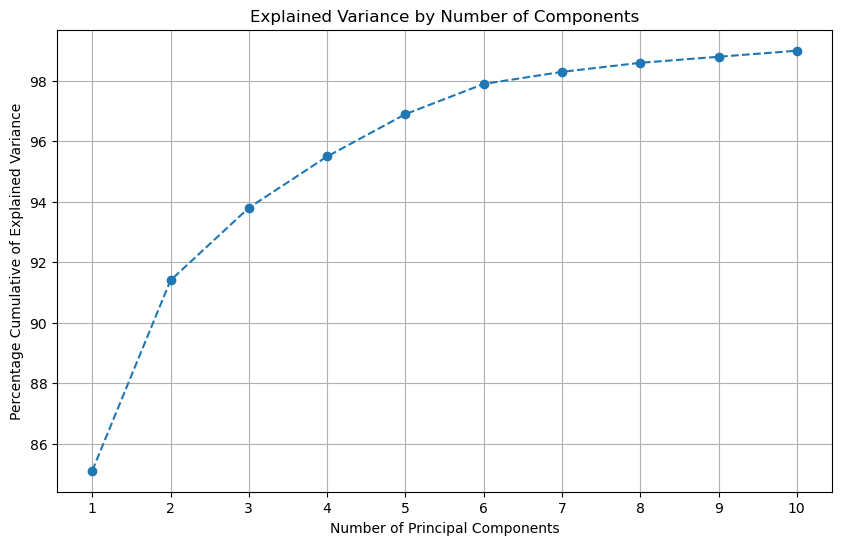

In [1853]:
def explain_variance(df_strain) -> None:  
    """
    Descripition: Plots the explained variance by number of components for PCA.

    Args:
        df_strain (pd DataFrame): The data.

    Returns:
        None    
    """
    # Fit PCA on the entire strain data (matrix-wise)
    # Set the number of components directly (e.g., 5 components)
    pca = PCA(n_components=10)
    pca.fit(df_strain)
    # 
    # Get the explained variance ratio
    per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

    # Plot the cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(per_var) + 1), per_var.cumsum(), marker="o", linestyle="--")
    plt.grid()
    plt.ylabel("Percentage Cumulative of Explained Variance")
    plt.xlabel("Number of Principal Components")
    plt.xticks(range(1, len(per_var) + 1, 1))
    plt.title("Explained Variance by Number of Components")
    plt.show()

explain_variance(df_strain)

In [1854]:
def do_pca(n_components, df_strain):
    """
    Description: Perform PCA on the data.

    Args:
        n_components (int): The number of principal components to keep.
        df_strain (pd DataFrame): The data.

    Returns:
        df_pca (pd DataFrame): The principal components for each timestamp.
        normalized_pca_components (np array) : The normalized principal components.
    """
    # Perform PCA
    pca = PCA(n_components=n_components)

    # Fit PCA on the entire strain data (matrix-wise)
    pca.fit(df_strain)

    # Apply PCA to the entire strain data (matrix-wise)
    pca_results = pca.transform(df_strain)

    # Normalize the results
    normalized_pca_components = StandardScaler().fit_transform(pca_results)
    # normalized_pca_components = MinMaxScaler().fit_transform(pca_results)

    # Convert results into a DataFrame
    df_pca = pd.DataFrame(normalized_pca_components, columns=[f'PC{i+1}' for i in range(n_components)])

    # Add timestamps back
    df_pca.insert(0, 'Timestamp', df['Timestamp'].values)       #2009-11-30 040000
    # df_pca.insert(0, '2009-11-30 040000', df['2009-11-30 040000'].values)

    return normalized_pca_components, df_pca

n_components = 10
normalized_pca_components, df_pca = do_pca(n_components, df_strain)

#### KMeans Clustering

In [1855]:
# def kmeans_clustering(normalized_pca_components, df, n_clusters):
#     """
#     Description: Perform K-Means clustering on the normalized PCA components and visualize the clusters.
#     Args:
#         normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
#         df (pd DataFrame): The original DataFrame including the timestamps.
#         n_clusters (int): The number of clusters to create.

#     Returns:
#         data_with_KMeans (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels.
#     """
   
#     kmeans = KMeans(n_clusters, random_state=42)
#     clusters = kmeans.fit_predict(normalized_pca_components)

#     # Add cluster labels to your original data (without overwriting)
#     data_with_KMeans = df.copy()  # Make a copy to preserve the original DataFrame

#     # Insert the clusters as the second column (at index 1)
#     data_with_KMeans.insert(1, 'Cluster', clusters)

#     # Count the number of data points assigned to each cluster
#     cluster_counts = {i: sum(clusters == i) for i in range(n_clusters)}

#     # Plot the clusters
#     plt.figure(figsize=(10, 6))
#     scatter = sns.scatterplot(x=normalized_pca_components[:, 0], y=normalized_pca_components[:, 1], hue=clusters, palette="viridis", s=100, alpha=0.7)

#     # Create custom labels for the legend with the cluster counts
#     legend_labels = [f'Cluster {i} (n={cluster_counts[i]})' for i in range(n_clusters)]
#     handles, _ = scatter.get_legend_handles_labels()

#     # Set the custom labels in the legend
#     plt.legend(handles=handles, labels=legend_labels, title='Cluster')

#     # Label the axes
#     plt.xlabel("Principal Component 1")
#     plt.ylabel("Principal Component 2")
#     plt.title("PCA + KMeans Clustering")

#     # Show the plot
#     plt.show()

#     # Show the updated DataFrame with the Cluster column as the second column
#     return data_with_KMeans

# n_components = 10
# normalized_pca_components, df_pca = do_pca(n_components, df_strain)

# n_clusters = 8
# data_with_KMeans = kmeans_clustering(normalized_pca_components, df, n_clusters)

#### Plot the cluster assignment over time

In [1856]:
def plot_clusters_over_time(data_with_clusters, method) -> None:
    """
    Plot the assignment to clusters over time, only displaying active clusters.
    
    Args:
        data_with_clusters (pd.DataFrame): DataFrame with 'Timestamp' and 'Cluster' columns.
        method (str): Name of the clustering method for the plot title.
    """
    # Convert timestamps
    data_with_clusters['Timestamp'] = pd.to_datetime(data_with_clusters['Timestamp'])

    # Identify active clusters (those actually used)
    active_clusters = sorted(data_with_clusters['Cluster'].dropna().unique())

    # Create Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=data_with_clusters['Timestamp'], 
        y=data_with_clusters['Cluster'], 
        mode='markers+lines',
        marker=dict(
            size=6, 
            color=data_with_clusters['Cluster'], 
            colorscale='Viridis',
            colorbar=dict(title='Cluster')
        ),
        line=dict(width=0.5, color='gray')
    ))

    # Update layout
    fig.update_layout(
        title=f'Assignment to Clusters Over Time with {method} Clustering',
        xaxis_title='Time',
        yaxis_title='Cluster',
        xaxis_tickangle=-45,
        yaxis=dict(
            tickmode='array',
            tickvals=active_clusters,
            ticktext=[str(c) for c in active_clusters]
        )
    )

    fig.show()
# plot_clusters_over_time(data_with_KMeans, 'KMeans')

#### Plot the mean distribution for each cluster and the standard deviation

In [1857]:
def plot_cluster_mean_and_std(data_with_clusters, clusters_to_keep, method) -> None:
    """
    Plot the mean strain values for each cluster with uncertainty (standard deviation).

    Args:
        data_with_clusters (pd.DataFrame): DataFrame with 'Timestamp' and 'Cluster' columns,
                                           other columns should be numeric sensor data (e.g., distances).
        clusters_to_keep (list): List of cluster labels to keep (e.g., [0, 1, 2]) or ['all'] to keep all.
        method (str): Name of clustering method for plot title.
    """
    # Get unique clusters and normalize types
    cluster_col = data_with_clusters['Cluster'].dropna()
    unique_clusters = cluster_col.astype(str).unique()

    # Normalize user input
    if clusters_to_keep == ['all']:
        clusters_to_keep = unique_clusters
    else:
        clusters_to_keep = [str(c) for c in clusters_to_keep]

    # Drop timestamp for clustering-related stats
    df_mean = data_with_clusters.drop(columns='Timestamp').groupby('Cluster').mean()
    df_std = data_with_clusters.drop(columns='Timestamp').groupby('Cluster').std()

    # Filter to desired clusters
    df_mean = df_mean.loc[df_mean.index.astype(str).isin(clusters_to_keep)]
    df_std = df_std.loc[df_std.index.astype(str).isin(clusters_to_keep)]

    x_values = pd.to_numeric(df_mean.columns, errors='coerce')
    average_std = df_std.mean(axis=1)

    # Plot
    plt.figure(figsize=(30, 6))
    for i, cluster in enumerate(df_mean.index):
        plt.plot(x_values, df_mean.loc[cluster], label=f'Cluster {cluster} - Mean, Avg. std: {average_std[cluster]:.2f}', linewidth=2)
        plt.fill_between(x_values,
                         df_mean.loc[cluster] - df_std.loc[cluster],
                         df_mean.loc[cluster] + df_std.loc[cluster],
                         alpha=0.3)

    plt.xlabel('Distance [m]')
    plt.ylabel('Strain (Mean Value)')
    plt.title(f'{method} Clustering Centroids with Uncertainty (Standard Deviation)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()


# clusters_to_keep = ['all'] # 'all' or a list of cluster indices
# plot_cluster_mean_and_std(data_with_KMeans, clusters_to_keep, 'KMeans')

## gmm clustering

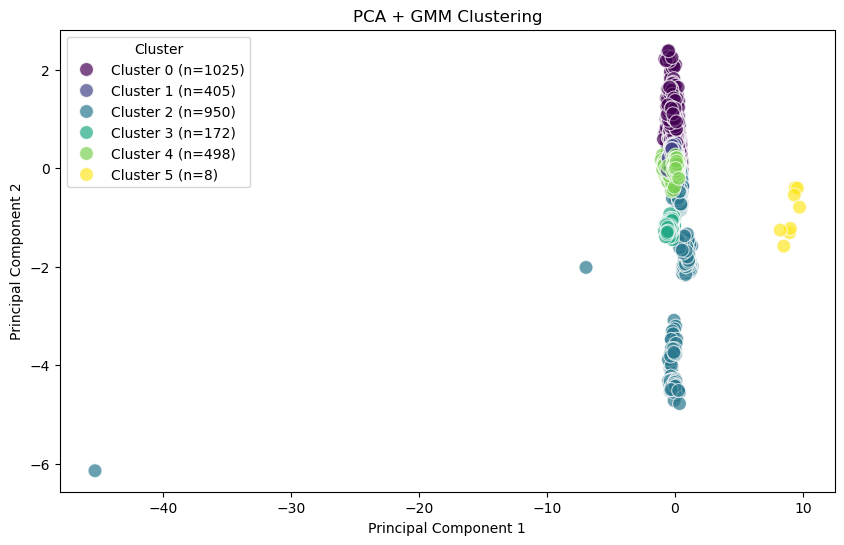

Timestamp  Cluster  Assigned_Cluster_Prob   0.0  \
0     2009-11-30 040000        2               1.000000 -13.0   
2     2009-12-02 040000        2               1.000000  27.0   
3     2009-12-03 040000        2               1.000000 -12.0   
11    2009-12-12 040000        2               0.999916  17.0   
16    2009-12-17 040000        2               1.000000  44.0   
...                 ...      ...                    ...   ...   
3883  2021-05-05 040000        4               1.000000  40.0   
3900  2021-05-22 040000        4               1.000000  55.0   
3910  2021-06-04 040000        4               1.000000  64.0   
3916  2021-06-10 040000        4               1.000000  42.0   
3918  2021-06-11 120000        4               1.000000  33.0   

      0.10000000000000009  0.20999999999999996  0.31000000000000005  \
0                    -8.0                 -4.0                  3.0   
2                    23.0                 19.0                 15.0   
3                   -11.0                 -9.0                 -6.0   
11                   17.0                 19.0                 19.0   
16                   41.0                 39.0                 35.0   
...                   ...                  ...                  ...   
3883                 30.0                 43.0                 56.0   
3900                 47.0                 62.0                 76.0   
3910                 55.0                 64.0                 73.0   
3916                 29.0                 40.0                 52.0   
3918                 25.0                 39.0                 53.0   

      0.41000000000000014  0.5099999999999998  0.6099999999999999  ...  \
0                     7.0                13.0                16.0  ...   
2                     9.0                 4.0                 1.0  ...   
3                    -6.0                -8.0                -7.0  ...   
11                   19.0                20.0                18.0  ...   
16                   32.0                30.0                29.0  ...   
...                   ...                 ...                 ...  ...   
3883                 55.0                31.0                 9.0  ...   
3900                 72.0                41.0                13.0  ...   
3910                 70.0                46.0                26.0  ...   
3916                 49.0                23.0                 1.0  ...   
3918                 52.0                27.0                 4.0  ...   

      160.82  160.92  161.03  161.13  161.23  161.32999999999998  161.43  \
0       -2.0    -4.0    -1.0     4.0     2.0                 9.0    19.0   
2      -37.0   -28.0   -26.0    -8.0    -6.0               -13.0   -18.0   
3       -2.0    12.0    22.0    36.0    32.0                39.0    41.0   
11       4.0    12.0    15.0    18.0    10.0                12.0    22.0   
16     -12.0    11.0    26.0    38.0    28.0                18.0    16.0   
...      ...     ...     ...     ...     ...                 ...     ...   
3883     1.0   -11.0   -25.0   -25.0   -30.0               -67.0  -111.0   
3900   -30.0   -37.0   -42.0   -33.0   -32.0               -70.0  -115.0   
3910  -120.0  -140.0  -140.0  -123.0  -114.0              -144.0  -180.0   
3916   -49.0   -65.0   -66.0   -51.0   -47.0               -91.0  -143.0   
3918   -95.0  -115.0  -118.0  -106.0  -103.0              -145.0  -192.0   

      161.53  161.64  161.73999999999998  
0       32.0    44.0                44.0  
2      -23.0   -29.0               -39.0  
3       42.0    34.0                25.0  
11      21.0    30.0                29.0  
16       2.0   -11.0               -36.0  
...      ...     ...                 ...  
3883  -119.0   -79.0               -57.0  
3900  -121.0   -81.0               -56.0  
3910  -186.0  -144.0              -114.0  
3916  -146.0  -100.0               -70.0  
3918  -189.0  -135.0               -97.0  

[3058 rows x 1594 columns]

In [1858]:
def gmm_clustering(normalized_pca_components, df, n_clusters):
    """
    Description: Perform GMM clustering on the normalized PCA components and visualize the clusters.
    Args:
        normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
        df (pd DataFrame): The original DataFrame including the timestamps.
        n_clusters (int): The number of clusters to create.

    Returns:
        data_with_gmm (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels.
    """
   
    gmm = GaussianMixture(n_clusters, random_state=42)
    clusters = gmm.fit_predict(normalized_pca_components)

    # Extract cluster probabilities
    probabilities = gmm.predict_proba(normalized_pca_components)

    # Get the probability of the assigned cluster
    assigned_prob = probabilities[np.arange(len(clusters)), clusters]

    # Add cluster labels to your original data (without overwriting)
    data_with_gmm = df.copy()  # Make a copy to preserve the original DataFrame

    # Insert the clusters as the second column (at index 1)
    data_with_gmm.insert(1, 'Cluster', clusters)

    data_with_gmm.insert(2, 'Assigned_Cluster_Prob', assigned_prob)  # Insert probability for the assigned cluster


    # Count the number of data points assigned to each cluster
    cluster_counts = {i: sum(clusters == i) for i in range(n_clusters)}

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=normalized_pca_components[:, 0], y=normalized_pca_components[:, 1], hue=clusters, palette="viridis", s=100, alpha=0.7)

    # Create custom labels for the legend with the cluster counts
    legend_labels = [f'Cluster {i} (n={cluster_counts[i]})' for i in range(n_clusters)]
    handles, _ = scatter.get_legend_handles_labels()

    # Set the custom labels in the legend
    plt.legend(handles=handles, labels=legend_labels, title='Cluster')

    # Label the axes
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA + GMM Clustering")

    # Show the plot
    plt.show()

    # Show the updated DataFrame with the Cluster column as the second column
    return data_with_gmm

n_components = 15
normalized_pca_components, df_pca = do_pca(n_components, df_strain)

n_clusters = 6
data_with_gmm = gmm_clustering(normalized_pca_components, df, n_clusters)
data_with_gmm

In [1859]:
plot_clusters_over_time(data_with_gmm, 'GMM')

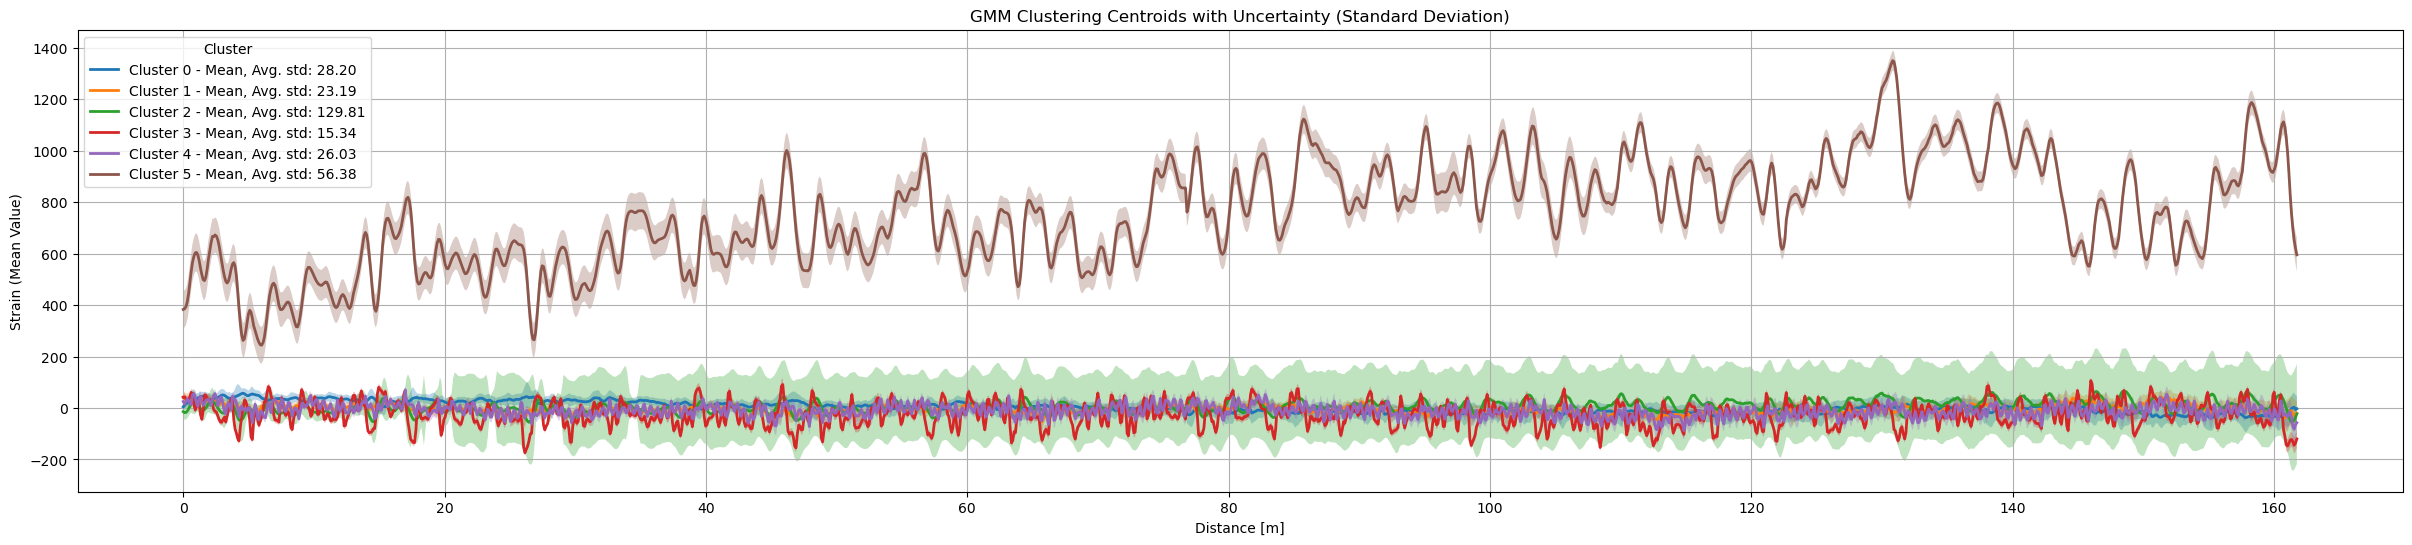

In [1860]:
clusters_to_keep = ['all'] # 'all' or a list of cluster indices
plot_cluster_mean_and_std(data_with_gmm, clusters_to_keep, 'GMM')

## SLIDING WINDOW DPGMM clustering


In [1861]:
from sklearn.mixture import BayesianGaussianMixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


# === Symmetric KL divergence (Jeffrey's divergence) ===
def kl_divergence(mu0, cov0, mu1, cov1):
    d = mu0.shape[0]
    cov1_inv = np.linalg.inv(cov1)
    trace_term = np.trace(cov1_inv @ cov0)
    diff = mu1 - mu0
    quad_term = diff.T @ cov1_inv @ diff
    log_det_term = np.log(np.linalg.det(cov1) / np.linalg.det(cov0))
    return 0.5 * (trace_term + quad_term - d + log_det_term)

def jeffreys_divergence(mu0, cov0, mu1, cov1):
    return 0.5 * (kl_divergence(mu0, cov0, mu1, cov1) + kl_divergence(mu1, cov1, mu0, cov0))

def merge_clusters_by_divergence(dpgmm, labels, threshold):
    unique_labels = np.unique(labels)
    if len(unique_labels) <= 1:
        return labels

    means = dpgmm.means_
    covariances = dpgmm.covariances_
    label_indices = [label for label in unique_labels if np.sum(labels == label) > 0]

    distance_matrix = np.zeros((len(label_indices), len(label_indices)))
    for i, idx_i in enumerate(label_indices):
        for j, idx_j in enumerate(label_indices):
            if i < j:
                dist = jeffreys_divergence(means[idx_i], covariances[idx_i], means[idx_j], covariances[idx_j])
                distance_matrix[i, j] = distance_matrix[j, i] = dist

    # Compute condensed distance matrix
    condensed_distance = squareform(distance_matrix, checks=False)
    Z = linkage(condensed_distance, method='average')
    new_cluster_ids = fcluster(Z, t=threshold, criterion='distance')
    label_map = {old: new for old, new in zip(label_indices, new_cluster_ids)}
    merged_labels = np.array([label_map.get(label, -1) for label in labels])

    return merged_labels


def streaming_dpgmm_clustering(normalized_pca_components, df, n_points, window_size, step_size, max_components, merge_threshold, merge_within_window):
    prior = 1
    all_labels = np.full(len(df), -1)
    all_probs = np.zeros(len(df))
    all_results = []

    # === Initial fit ===
    initial_data = normalized_pca_components[:n_points]
    dpgmm_init = BayesianGaussianMixture(
        n_components=max_components,
        covariance_type='full',
        weight_concentration_prior_type='dirichlet_process',
        weight_concentration_prior=prior,
        max_iter=1000,
        tol=1e-3,
        init_params='kmeans',
        random_state=42
    )
    dpgmm_init.fit(initial_data)
    initial_labels = dpgmm_init.predict(initial_data)
    if merge_within_window:
        initial_labels = merge_clusters_by_divergence(dpgmm_init, initial_labels, merge_threshold)
    initial_probs = dpgmm_init.predict_proba(initial_data)
    initial_max_probs = initial_probs[np.arange(len(initial_labels)), initial_labels]
    all_labels[:n_points] = initial_labels
    all_probs[:n_points] = initial_max_probs

    print(f"Initial fit => Clusters used: {np.sum(dpgmm_init.weights_ > 0.01)}")

    # === Streaming windows ===
    for start in range(n_points, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_data = normalized_pca_components[start:end]
        memory_data = normalized_pca_components[:end]

        dpgmm = BayesianGaussianMixture(
            n_components=max_components,
            covariance_type='full',
            weight_concentration_prior_type='dirichlet_process',
            weight_concentration_prior=prior,
            max_iter=1500,
            tol=1e-3,
            init_params='kmeans',
            random_state=42
        )
        dpgmm.fit(memory_data)

        labels = dpgmm.predict(window_data)
        if merge_within_window:
            labels = merge_clusters_by_divergence(dpgmm, labels, merge_threshold)

        probs = dpgmm.predict_proba(window_data)
        max_probs = probs[np.arange(len(labels)), labels]

        all_labels[start:end] = labels
        all_probs[start:end] = max_probs

        active_clusters = np.sum(dpgmm.weights_ > 0.01)
        print(f"Window {start}-{end} => Active clusters: {active_clusters}, Top 5 weights: {np.round(dpgmm.weights_[:5], 3)}")

        all_results.append({
            'start': start,
            'end': end,
            'labels': labels,
            'probs': max_probs
        })

    # === Final window ===
    final_start = start + step_size
    if final_start < len(df):
        final_data = normalized_pca_components[final_start:]
        memory_data = normalized_pca_components[:]

        dpgmm_final = BayesianGaussianMixture(
            n_components=max_components,
            covariance_type='full',
            weight_concentration_prior_type='dirichlet_process',
            weight_concentration_prior=prior,
            max_iter=1000,
            tol=1e-3,
            init_params='kmeans',
            random_state=42
        )
        dpgmm_final.fit(memory_data)

        final_labels = dpgmm_final.predict(final_data)
        if merge_within_window:
            final_labels = merge_clusters_by_divergence(dpgmm_final, final_labels, merge_threshold)

        final_probs = dpgmm_final.predict_proba(final_data)
        final_max_probs = final_probs[np.arange(len(final_labels)), final_labels]

        all_labels[final_start:] = final_labels
        all_probs[final_start:] = final_max_probs

        print(f"Final window {final_start}-{len(df)} => Active clusters: {np.sum(dpgmm_final.weights_ > 0.01)}")

        all_results.append({
            'start': final_start,
            'end': len(df),
            'labels': final_labels,
            'probs': final_max_probs
        })
    else:
        dpgmm_final = dpgmm  # fallback

    # === Merge clusters outside the window loop === (if enabled)
    if not merge_within_window:
            # === Merge Clusters using Jeffrey's Divergence ===
        unique_labels = np.unique(all_labels)
        if -1 in unique_labels:
            unique_labels = unique_labels[unique_labels != -1]

        if len(unique_labels) > 1:
            means = dpgmm_final.means_
            covariances = dpgmm_final.covariances_
            label_indices = [label for label in unique_labels if np.sum(all_labels == label) > 0]

            distance_matrix = np.zeros((len(label_indices), len(label_indices)))
            for i, idx_i in enumerate(label_indices):
                for j, idx_j in enumerate(label_indices):
                    if i < j:
                        dist = jeffreys_divergence(means[idx_i], covariances[idx_i], means[idx_j], covariances[idx_j])
                        distance_matrix[i, j] = distance_matrix[j, i] = dist

        sns.heatmap(distance_matrix, cmap='viridis')
        plt.title("Jeffrey's Divergence Between Cluster Gaussians")
        plt.show()

        Z = linkage(distance_matrix, method='average')
        new_cluster_ids = fcluster(Z, t=merge_threshold, criterion='distance')
        label_map = {old: new for old, new in zip(label_indices, new_cluster_ids)}
        all_labels = np.array([label_map.get(label, -1) for label in all_labels])


    # === Return DataFrame with results ===
    df_result = df.copy()
    df_result.insert(1, 'Cluster', all_labels)
    df_result.insert(2, 'Assigned_Cluster_Prob', all_probs)

    used_clusters = np.unique(all_labels)
    used_clusters = used_clusters[used_clusters != -1]
    palette = sns.color_palette('viridis', len(used_clusters))
    cluster_color_map = {label: palette[i] for i, label in enumerate(used_clusters)}
    cluster_color_map[-1] = (0.6, 0.6, 0.6)

    # === Plot clusters with counts in legend ===
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(
        x=normalized_pca_components[:, 0],
        y=normalized_pca_components[:, 1],
        hue=all_labels,
        palette=cluster_color_map,
        s=60,
        alpha=0.7,
        legend='full'
    )

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Streaming PCA + DPGMM Clustering")

    handles, labels = ax.get_legend_handles_labels()
    label_counts = pd.Series(all_labels).value_counts().sort_index()

    new_labels = []
    for lbl in labels:
        try:
            cluster_id = int(lbl)
            count = label_counts.get(cluster_id, 0)
            new_labels.append(f"Cluster {cluster_id} ({count} samples)")
        except ValueError:
            new_labels.append(lbl)

    ax.legend(handles=handles, labels=new_labels, title='Cluster', loc='upper right')
    plt.show()

    return df_result, all_results


data_with_dpgmm, _ = streaming_dpgmm_clustering(
    normalized_pca_components=normalized_pca_components,
    df=df,
    n_points=1000,
    window_size=400,
    step_size=100,
    max_components=100,
    merge_threshold=60,
    merge_within_window=True  # Toggle ON/OFF
)

c:\Users\gwd007\AppData\Local\anaconda3\envs\exjobb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



Initial fit => Clusters used: 24


KeyboardInterrupt: 

In [ ]:
plot_clusters_over_time(data_with_dpgmm, 'DPGMM')

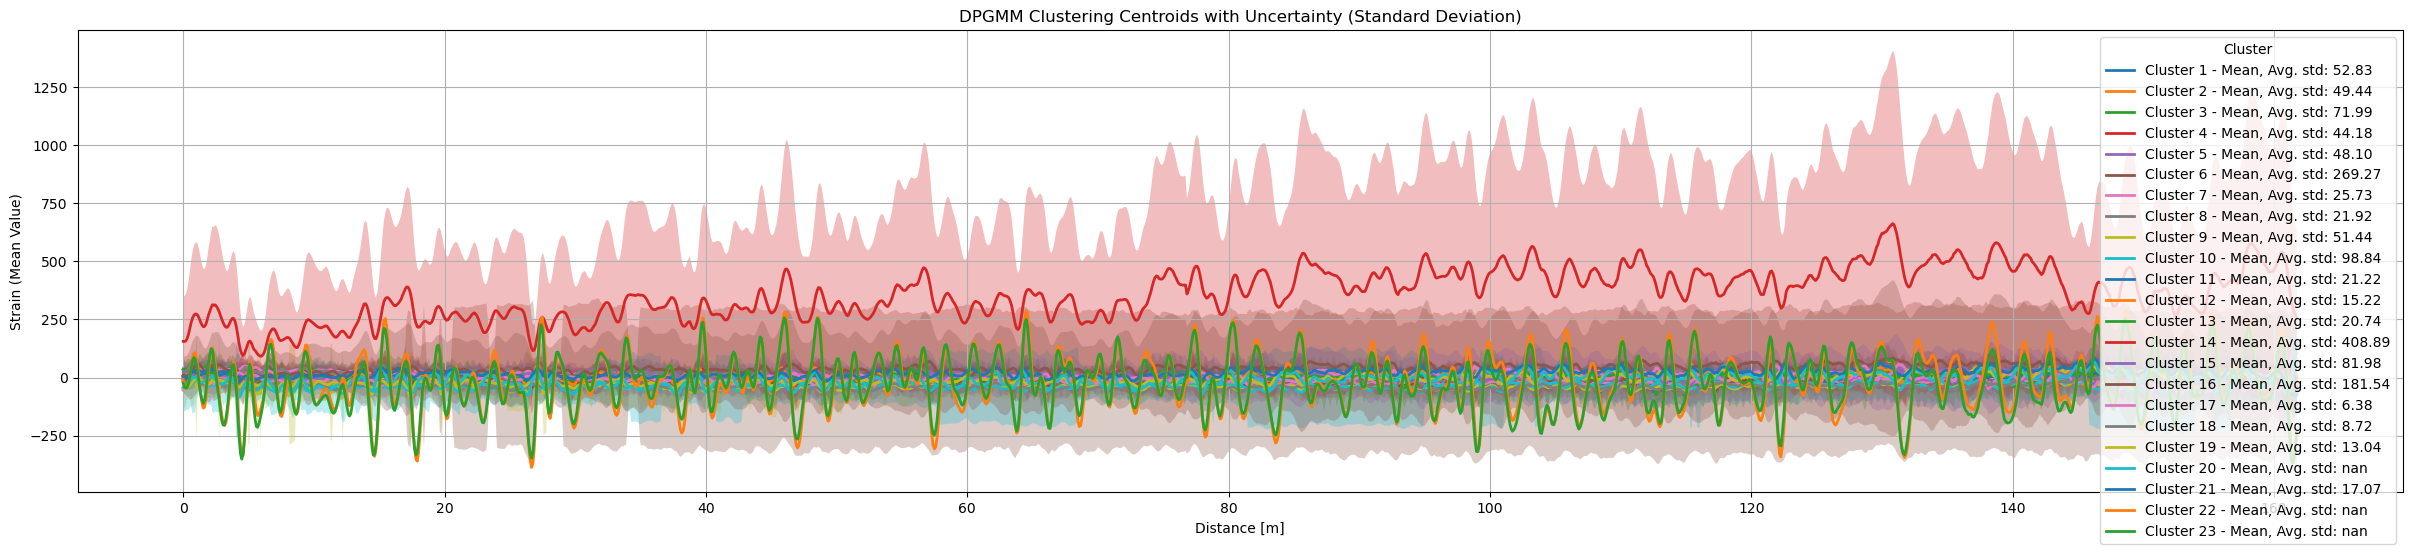

In [ ]:

clusters_to_keep = ['all'] # 'all' or a list of cluster indices
plot_cluster_mean_and_std(data_with_dpgmm, clusters_to_keep, method='DPGMM')

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clustering_quality(features, labels):
    # Filter out unassigned data points (label -1)
    mask = labels != -1
    filtered_features = features[mask]
    filtered_labels = labels[mask]

    if len(np.unique(filtered_labels)) < 2:
        print("Not enough clusters to evaluate.")
        return None, None

    silhouette = silhouette_score(filtered_features, filtered_labels)
    dbi = davies_bouldin_score(filtered_features, filtered_labels)

    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {dbi:.3f}")
    
    return silhouette, dbi

silhouette, dbi = evaluate_clustering_quality(
    features=normalized_pca_components,
    labels=data_with_dpgmm['Cluster'].values
)


Silhouette Score: -0.103
Davies-Bouldin Index: 2.710


## DBscan clustering

In [ ]:
# def dbscan_clustering(normalized_pca_components, df, eps, min_samples):
#     """
#     Description: Perform DBSCAN clustering on the normalized PCA components and visualize the clusters.
#     Args:
#         normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
#         df (pd DataFrame): The original DataFrame including the timestamps.
#         n_clusters (int): The number of clusters to create.

#     Returns:
#         data_with_dbscan (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels.
#     """
   
#     # Fit the DBSCAN model
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     clusters = dbscan.fit_predict(normalized_pca_components)

#     # Add cluster labels to your original data (without overwriting)
#     data_with_dbscan = df.copy()  # Make a copy to preserve the original DataFrame

#     # Insert the clusters as the second column (at index 1)
#     data_with_dbscan.insert(1, 'Cluster', clusters)

#     # Count the number of data points assigned to each cluster
#     cluster_counts = {i: sum(clusters == i) for i in range(n_clusters)}

#     # Plot the clusters
#     plt.figure(figsize=(10, 6))
#     scatter = sns.scatterplot(x=normalized_pca_components[:, 1], y=normalized_pca_components[:, 2], hue=clusters, palette="viridis", s=100, alpha=0.7)

#     # Create custom labels for the legend with the cluster counts
#     legend_labels = [f'Cluster {i} (n={cluster_counts[i]})' for i in range(n_clusters)]
#     handles, _ = scatter.get_legend_handles_labels()

#     # Set the custom labels in the legend
#     plt.legend(handles=handles, labels=legend_labels, title='Cluster')

#     # Label the axes
#     plt.xlabel("Principal Component 1")
#     plt.ylabel("Principal Component 2")
#     plt.title("PCA + DBSCAN Clustering")

#     # Show the plot
#     plt.show()

#     # Show the updated DataFrame with the Cluster column as the second column
#     return data_with_dbscan

# n_components = 10
# normalized_pca_components, df_pca = do_pca(n_components, df_strain)

# data_with_dbscan = dbscan_clustering(normalized_pca_components, df, eps=0.5, min_samples=50)

In [ ]:
# clusters_to_keep = ['all'] # 'all' or a list of cluster indices
# plot_cluster_mean_and_std(data_with_dbscan, clusters_to_keep, 'DBSCAN')

In [ ]:
# # Assuming 'Timestamp' is a column with string dates, we convert it to datetime format.
# data_with_dbscan['Timestamp'] = pd.to_datetime(data_with_dbscan['Timestamp'])

# # Create the Plotly figure
# fig = go.Figure()

# # Add a scatter plot (you can choose 'line' or 'scatter' depending on the style you want)
# fig.add_trace(go.Scatter(x=data_with_dbscan['Timestamp'], 
#                          y=data_with_dbscan['Cluster'], 
#                          mode='markers+lines',  # markers and lines
#                          marker=dict(size=8, 
#                                      color=data_with_dbscan['Cluster'],  # Color by cluster value
#                                      colorscale='Viridis',  # You can change the colorscale here
#                                      colorbar=dict(title='Cluster')),  # Add a color bar to show the scale
#                          line=dict(width=1, color='grey')))  # Customizing line color and width

# # Update layout with title and labels
# fig.update_layout(
#     title='Assignment to Clusters Over Time with DBSCAN Clustering',
#     xaxis_title='Time',
#     yaxis_title='Cluster',
#     xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
#     yaxis=dict(tickmode='linear', tick0=0, dtick=1)  # Set y-tick step size to 1
# )

# # Show the figure
# fig.show()

In [ ]:
# data_venn = pd.DataFrame()
# data_venn['KMeans'] = data_with_KMeans['Cluster']
# data_venn['GMM'] = data_with_gmm['Cluster']
# data_venn['DBSCAN'] = data_with_dbscan['Cluster']

# # Find the timestamps where all three clustering methods assigned the same cluster
# # Find the rows where all three columns have the same value
# set1 = data_venn[data_venn['KMeans'] == data_venn['GMM']][data_venn['KMeans'] == data_venn['DBSCAN']].index
# set2 = data_venn[data_venn['KMeans'] == data_venn['GMM']][data_venn['KMeans'] != data_venn['DBSCAN']].index
# set3 = data_venn[data_venn['KMeans'] != data_venn['GMM']][data_venn['KMeans'] == data_venn['DBSCAN']].index
# set4 = data_venn[data_venn['KMeans'] != data_venn['GMM']][data_venn['KMeans'] != data_venn['DBSCAN']][data_venn['GMM'] == data_venn['DBSCAN']].index
# set5 = data_venn[data_venn['KMeans'] != data_venn['GMM']][data_venn['KMeans'] != data_venn['DBSCAN']][data_venn['GMM'] != data_venn['DBSCAN']].index

# count_set1 = len(set1)
# count_set2 = len(set2)
# count_set3 = len(set3)
# count_set4 = len(set4)
# count_set5 = len(set5)

# print("Number of timestamps where all three clustering methods assigned the same cluster: ", count_set1)
# print("Number of timestamps where KMeans and GMM assigned the same cluster but DBSCAN did not: ", count_set2)
# print("Number of timestamps where KMeans and DBSCAN assigned the same cluster but GMM did not: ", count_set3)
# print("Number of timestamps where GMM and DBSCAN assigned the same cluster but KMeans did not: ", count_set4)
# print("Number of timestamps where all three clustering methods assigned different clusters: ", count_set5)

#### Number of clusters

In [ ]:
# def evaluate_clusters(normalized_pca_components, n_clusters) -> None:
#     """
#     Description: Evaluate different clustering algorithms (KMeans, GMM, DBSCAN) using Silhouette Score and Davies-Bouldin Index.

#     Args:
#         normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
#         n_clusters (int): The maximum number of clusters to evaluate.

#     Returns:
#         None    
#     """

#     # Initialize lists to store inertia and Davies-Bouldin index for KMeans
#     silhouette_kmeans = []  # Sum of squared distances of samples to their closest cluster center
#     db_index_kmeans = []  # Davies-Bouldin Index

#     # Initialize lists to store inertia and Davies-Bouldin index for GMM
#     silhouette_gmm = []  
#     db_index_gmm = []  

#     # Initialize lists to store inertia and Davies-Bouldin index for DBSCAN
#     silhouette_dbscan = []  
#     db_index_dbscan = []  
 

#     # Loop over different number of clusters
#     for n in range(2, n_clusters + 1):

#         # KMeans Clustering
#         kmeans = KMeans(n_clusters=n, random_state=42)
#         kmeans_labels = kmeans.fit_predict(normalized_pca_components)

#         # Davies-Bouldin Index for KMeans
#         db_score_kmeans = davies_bouldin_score(normalized_pca_components, kmeans_labels)
#         db_index_kmeans.append(db_score_kmeans)
#         # Silhouette Score for KMeans
#         silhouette_kmeans.append(silhouette_score(normalized_pca_components, kmeans_labels))
        
#         print(f"K-Means - Number of clusters: {n}, Davies-Bouldin Index: {db_score_kmeans}, Silhouette Score: {silhouette_score(normalized_pca_components, kmeans_labels)}")

#         # GMM Clustering
#         gmm = GaussianMixture(n_components=n, random_state=42)
#         gmm_labels = gmm.fit_predict(normalized_pca_components)

#         # Davies-Bouldin Index for GMM
#         db_score_gmm = davies_bouldin_score(normalized_pca_components, gmm_labels)
#         db_index_gmm.append(db_score_gmm)
#         # Silhouette Score for GMM
#         silhouette_gmm.append(silhouette_score(normalized_pca_components, gmm_labels))
        
#         print(f"GMM - Number of components: {n}, Davies-Bouldin Index: {db_score_gmm}, Silhouette Score: {silhouette_score(normalized_pca_components, gmm_labels)}")

#         # DBSCAN Clustering (DBSCAN does not require number of clusters, so we use eps and min_samples)
#         dbscan = DBSCAN(eps=0.5, min_samples=5)
#         dbscan_labels = dbscan.fit_predict(normalized_pca_components)

#         # Davies-Bouldin Index for DBSCAN (ignoring -1 labels as noise points)
#         db_score_dbscan = davies_bouldin_score(normalized_pca_components[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
#         db_index_dbscan.append(db_score_dbscan)
        
#         # Silhouette Score for DBSCAN (ignoring -1 labels as noise points)
#         silhouette_dbscan.append(silhouette_score(normalized_pca_components[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]))
        
#         print(f"DBSCAN - Davies-Bouldin Index: {db_score_dbscan}, Silhouette Score: {silhouette_score(normalized_pca_components[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])}")

#     # Plot the Elbow graph and Davies-Bouldin Index in subplots
#     fig, axes = plt.subplots(2, 1, figsize=(10, 12))

#     # Elbow Method Plot (Inertia)
#     axes[0].plot(range(2, n_clusters+1), silhouette_kmeans, marker='o')
#     axes[0].plot(range(2, n_clusters+1), silhouette_gmm, marker='o')
#     # axes[0].plot(range(2, n_clusters+1), silhouette_dbscan, marker='o')
#     axes[0].set_title("Silhouette Score for Different Number of Clusters")
#     axes[0].set_xlabel("Number of Clusters")
#     axes[0].set_ylabel("Silhouette Score")
#     axes[0].legend(['KMeans', 'GMM', 'DBSCAN'])

#     # Davies-Bouldin Index Plot
#     axes[1].plot(range(2, n_clusters+1), db_index_kmeans, marker='o')
#     axes[1].plot(range(2, n_clusters+1), db_index_gmm, marker='o')
#     # axes[1].plot(range(2, n_clusters+1), db_index_dbscan, marker='o')
#     axes[1].set_title("Davies-Bouldin Index for Different Number of Clusters")
#     axes[1].set_xlabel("Number of Clusters")
#     axes[1].set_ylabel("Davies-Bouldin Index")
#     axes[1].legend(['KMeans', 'GMM','DBSCAN'])

#     plt.tight_layout()

#     plt.show()

# # Call the function with the normalized PCA components
# n_components = 8
# normalized_pca_components, df_pca = do_pca(n_components, normalized_pca_components)

# n_clusters = 10
# # evaluate_clusters(normalized_pca_components, n_clusters)
